## Load libraries and tools

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
logs = Callback()
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pickle
import timeit

import glob
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


## Loading image file paths and label to Pandas DataFrame

In [3]:
filepath_korean = "/Users/eunheelim/Capstone2/simple_images/korean500/*"
filepath_indian = "/Users/eunheelim/Capstone2/simple_images/indian500/*"

In [4]:
korean_files = [file for file in glob.iglob(filepath_korean)]
indian_files = [file for file in glob.iglob(filepath_indian)]

In [5]:
len(korean_files),len(indian_files)

(4650, 4998)

In [6]:
df_files = (
    pd.DataFrame({"filepath": korean_files, "label": np.zeros(len(korean_files))}).append(
    pd.DataFrame({"filepath": indian_files, "label": np.ones(len(indian_files))})
    ))

In [7]:
df_files.head()

,filepath,label
0,/Users/eunheelim/Capstone2/simple_images/korea...,0.0
1,/Users/eunheelim/Capstone2/simple_images/korea...,0.0
2,/Users/eunheelim/Capstone2/simple_images/korea...,0.0
3,/Users/eunheelim/Capstone2/simple_images/korea...,0.0
4,/Users/eunheelim/Capstone2/simple_images/korea...,0.0


## Splitting train and test set

In [8]:
df_train, df_test = train_test_split(df_files, test_size=0.2, random_state=1, shuffle=True)
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [9]:
df_train.shape

(7718, 2)

In [10]:
df_test.shape

(1930, 2)

## Functions to use for loading images 

In [11]:
def preprocess_image(image):  #Preprocessing image in color
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range
    return image.numpy()
    
def preprocess_image_gray(image): #Preprocessing image to gray scale
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = np.ceil(0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2])
    image /= 255.0
    return image

def load_and_preprocess_image(path):  # Loading and preprocessing color image 
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_image_gray(path): # Loading and preprocessing gray image 
    image = tf.io.read_file(path)
    return preprocess_image_gray(image)

## Showing sample images with labels

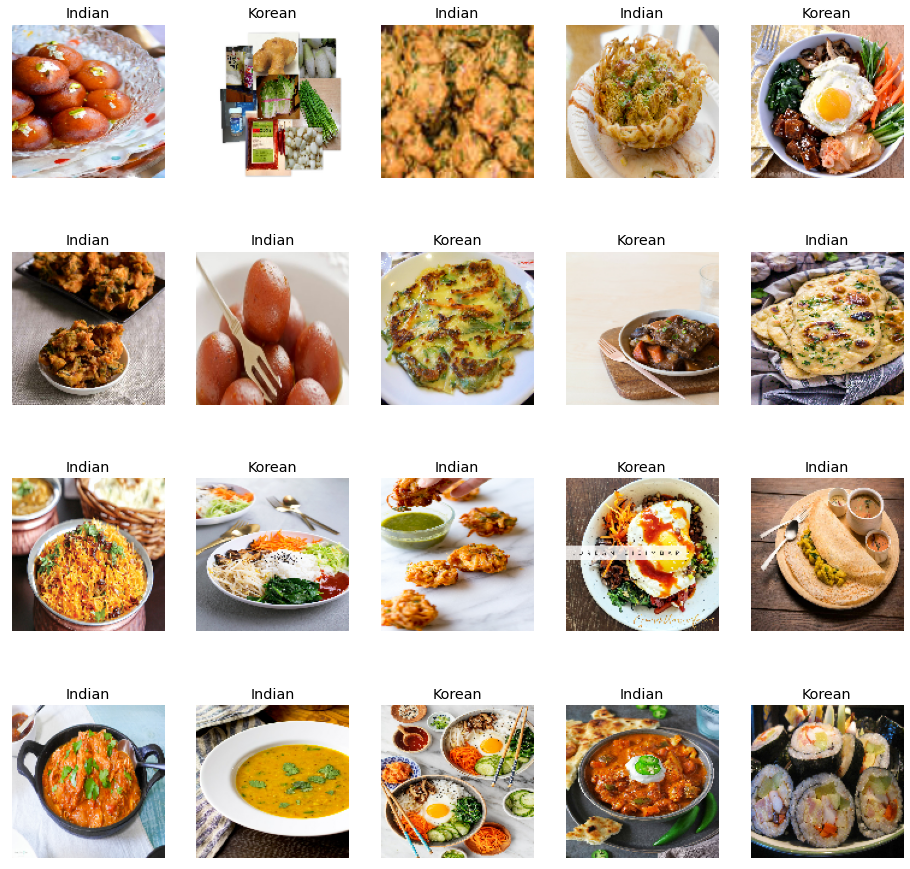

In [12]:
plt.figure(figsize=(16, 16))
for i in range(20):
    img = load_and_preprocess_image(df_train["filepath"].iloc[i])
    label = df_train["label"].iloc[i]
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    if label == 0:
        plt.title("Korean")
    elif label==1:
        plt.title("Indian")

plt.show()

## Setting train and test images and labels

In [13]:
train_labels = df_train['label'].to_numpy()

train_images = np.empty([df_train.shape[0], 128, 128,3])

for index,row in df_train.iterrows():
    try:
        img = load_and_preprocess_image(row['filepath']).reshape(1,128,128,3)
        train_images[index] = img
    except:
        print(row['filepath'])

/Users/eunheelim/Capstone2/simple_images/indian500/dosa_Image_458.jpg


In [14]:
test_labels = df_test['label'].to_numpy()

test_images = np.empty([df_test.shape[0], 128, 128, 3])

for index,row in df_test.iterrows():
    try:
        img = load_and_preprocess_image(row['filepath']).reshape(1,128,128,3)
        test_images[index] = img
    except:
        print(row['filepath'])

## Frequently used colors in Indian vs Korean cuision
 - Average R/G/B profile per image per cuision
 - Make gray scale to look at luminance between 0 and 1

In [15]:
# Creating Korean and Indian data frames
df_korean = df_files.loc[df_files["label"] == 0, "filepath"]
df_indian = df_files.loc[df_files["label"] == 1, "filepath"]

In [60]:
df_korean.head()

0    /Users/eunheelim/Capstone2/simple_images/korea...
1    /Users/eunheelim/Capstone2/simple_images/korea...
2    /Users/eunheelim/Capstone2/simple_images/korea...
3    /Users/eunheelim/Capstone2/simple_images/korea...
4    /Users/eunheelim/Capstone2/simple_images/korea...
Name: filepath, dtype: object

In [27]:
df_indian.shape

(4998,)

In [79]:
# Making array of R/G/B values in Korean cuisine images
korean_red = np.empty([len(df_korean),128*128])
korean_green = np.empty([len(df_korean),128*128])
korean_blue = np.empty([len(df_korean),128*128])


for i, row in enumerate(df_korean):
    img = load_and_preprocess_image(row)
    korean_red[i] = np.ravel(np.ceil(img[:, :, 0]*255))
    korean_green[i] = np.ravel(np.ceil(img[:, :, 1]*255))
    korean_blue[i] = np.ravel(np.ceil(img[:, :, 2]*255))

# Calculating gray scale values 
korean_gray =  np.ceil(0.2989 * korean_red + 0.5870 *korean_green + 0.1140 * korean_blue)

In [77]:
# Making array of R/G/B values in Indian cuisine images
indian_red = np.empty([len(df_indian),128*128])
indian_green = np.empty([len(df_indian),128*128])
indian_blue = np.empty([len(df_indian),128*128])

for i,row in enumerate(df_indian):
    try:
        img = load_and_preprocess_image(row)
        indian_red[i] = np.ravel(np.ceil(img[:, :, 0]*255))
        indian_green[i] = np.ravel(np.ceil(img[:, :, 1]*255))
        indian_blue[i] = np.ravel(np.ceil(img[:, :, 2]*255))
    except:
        print(i,row)
    
indian_gray =  np.ceil(0.2989 * indian_red + 0.5870 *indian_green + 0.1140 * indian_blue)

3438 /Users/eunheelim/Capstone2/simple_images/indian500/dosa_Image_458.jpg


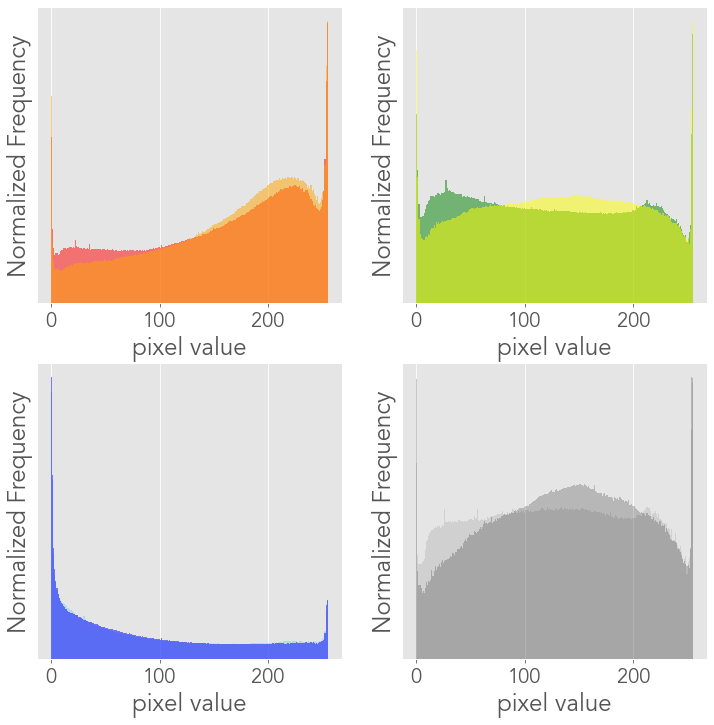

In [80]:
# Plotting R/G/B/G histogram 
fig = plt.figure(figsize=(12, 12))
plt.rcParams['font.size'] =20
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


ax1.hist(np.ravel(korean_red), bins=256, color='red', alpha=0.5, density= True)
ax1.hist(np.ravel(indian_red), bins=256, color='orange', alpha=0.5, density= True)
ax1.set_xlabel('pixel value')
ax1.set_ylabel('Normalized Frequency')
ax1.set_yticks([])


ax2.hist(np.ravel(korean_green), bins=256, color='green', alpha=0.5, density= True)
ax2.hist(np.ravel(indian_green), bins=256, color='yellow', alpha=0.5, density= True)
ax2.set_xlabel('pixel value')
ax2.set_ylabel('Normalized Frequency')
ax2.set_yticks([])

ax3.hist(np.ravel(korean_blue), bins=256, color='skyblue', alpha=0.5,  density= True)
ax3.hist(np.ravel(indian_blue), bins=256, color='blue', alpha=0.5, density= True)
ax3.set_xlabel('pixel value')
ax3.set_ylabel('Normalized Frequency')
ax3.set_yticks([])

ax4.hist(np.ravel(korean_gray), bins=256, color='gray', alpha=0.2, density= True)
ax4.hist(np.ravel(indian_gray), bins=256, color='black', alpha=0.2, density= True)
ax4.set_xlabel('pixel value')
ax4.set_ylabel('Normalized Frequency')
ax4.set_yticks([])

plt.show()

## Building a baseline model
 - Predicted labels are randomly assigned proportional to the train set labels

In [18]:
# Calculate the proportions of classes 0,1
prob = np.bincount(train_labels.astype(int))/len(train_labels)

In [20]:
prob

array([0.47978751, 0.52021249])

In [21]:
# Randomly generate an array of 0,1 with above probabilty
base_predicted = np.random.choice([0,1],len(test_labels),[0.47978751, 0.52021249])

In [22]:
def plot_confusion_matrix(test_labels, predicted_labels):
    
    #Create confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    
    #Plot confusion matrix
    plt.rcParams["font.family"] = "Avenir"
    plt.rcParams["font.size"] = 20
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues')
    ax.set_xticklabels(["Korean", "Indian"])
    ax.set_yticklabels(["Korean", "Indian"])
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")
    plt.show()
    return

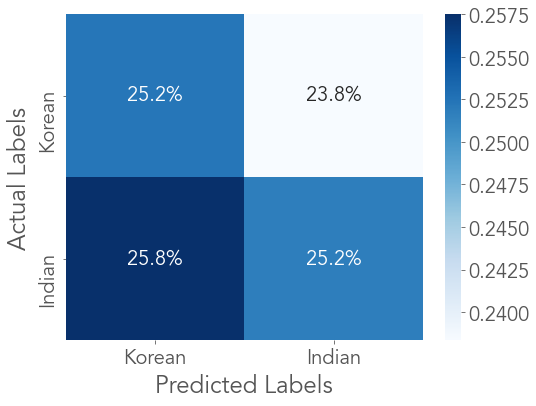

In [23]:
plot_confusion_matrix(test_labels, base_predicted)

## Neural Network

## Model without convolution layer

In [25]:
#Plot train and test accuracy vs epoch 
def plot_accuracy(history):
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'val'], loc='upper left')


    plt.show()
    return

### Model 1 : learning rate 0.0001, epochs = 30

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 6,291,971
Trainable params: 6,291,971
Non-trainable params: 0
_________________________________________________________________
None
Train on 6174 samples, validate on 1544 samples
Epoch 1/30
6174/6174 [==============================] - 7s 1ms/sample - loss: 0.8734 - accuracy: 0.5884 - val_loss: 0.5987 - val_accuracy: 0.6839
Epoch 2/30
6174/6174 [==============================] - 6s 929us/sample - loss: 0.6381 - accuracy: 0.6723 - val_loss: 0.6419 - val_accuracy: 0.6561
Epoch 3/30
6174/6174 [=======

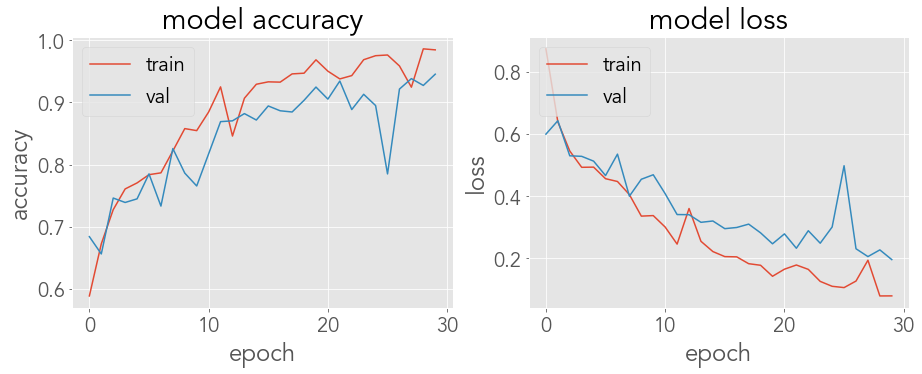

In [28]:
# Build a NN 
model_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(128, 128,3)),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(3,  activation = "softmax")
    ])

# Print model sumary
print(model_1.summary())

# Set optimizer to be used in model.compile
opt = keras.optimizers.Adam(learning_rate=0.0001)

# Compile model with optimzer, loss function, and metrics
model_1.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Save history for plotting
history =model_1.fit(train_images, train_labels, epochs=30, validation_split=0.2, verbose=1)

#Plot accuracy
plot_accuracy(history)


Test data, accuracy: 93.63%


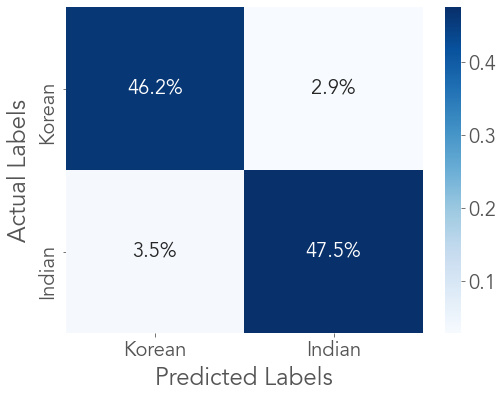

In [29]:
# Evaluate model with test images
test_loss, test_acc = model_1.evaluate(test_images, test_labels, verbose=0)
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))

# Make predictions on test set
prediction = model_1.predict(test_images)
predicted_labels = np.argmax(prediction, axis=1)

# Make Confusion matrix plot
plot_confusion_matrix(test_labels, predicted_labels)

### Model 2 : learning rate 0.000005, epochs = 100

Train on 6174 samples, validate on 1544 samples
Epoch 1/100
6174/6174 [==============================] - 6s 914us/sample - loss: 0.0500 - accuracy: 0.9969 - val_loss: 0.1866 - val_accuracy: 0.9508
Epoch 2/100
6174/6174 [==============================] - 5s 883us/sample - loss: 0.0469 - accuracy: 0.9979 - val_loss: 0.1855 - val_accuracy: 0.9508
Epoch 3/100
6174/6174 [==============================] - 6s 956us/sample - loss: 0.0463 - accuracy: 0.9976 - val_loss: 0.1848 - val_accuracy: 0.9495
Epoch 4/100
6174/6174 [==============================] - 6s 964us/sample - loss: 0.0456 - accuracy: 0.9977 - val_loss: 0.1937 - val_accuracy: 0.9430
Epoch 5/100
6174/6174 [==============================] - 6s 910us/sample - loss: 0.0444 - accuracy: 0.9982 - val_loss: 0.1837 - val_accuracy: 0.9514
Epoch 6/100
6174/6174 [==============================] - 6s 997us/sample - loss: 0.0451 - accuracy: 0.9972 - val_loss: 0.1838 - val_accuracy: 0.9475
Epoch 7/100
6174/6174 [==============================] - 6

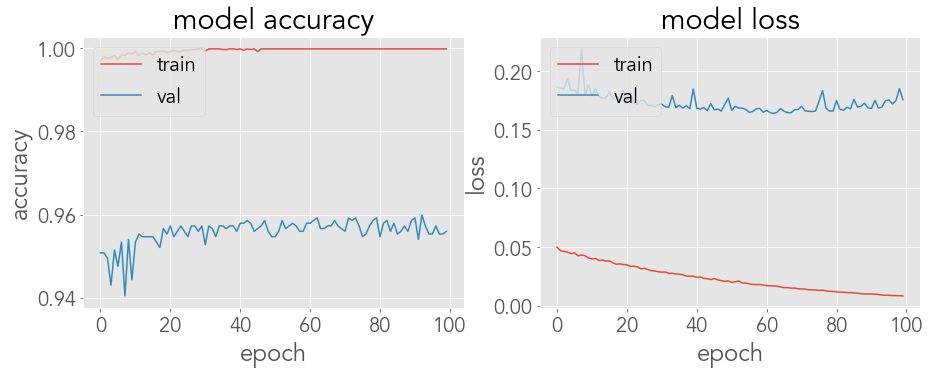

In [30]:
model_2 = model_1

opt = keras.optimizers.Adam(learning_rate=0.000005)

model_2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history =model_2.fit(train_images, train_labels, epochs=100, validation_split=0.2, verbose=1)

plot_accuracy(history)


Test data, accuracy: 94.92%


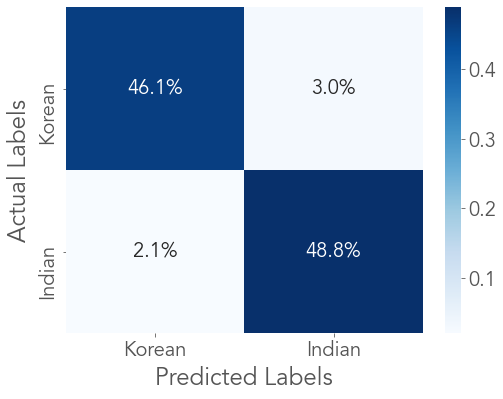

In [31]:
# Evaluate model with test images
test_loss, test_acc = model_2.evaluate(test_images, test_labels, verbose=0)
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))

# Make predictions on test set
prediction = model_2.predict(test_images)
predicted_labels = np.argmax(prediction, axis=1)

# Make Confusion matrix plot
plot_confusion_matrix(test_labels, predicted_labels)

## Create Convolutional Neural Network

## Model with 1 filter layer

Train on 6174 samples, validate on 1544 samples
Epoch 1/20
6174/6174 [==============================] - 24s 4ms/sample - loss: 0.7167 - accuracy: 0.5892 - val_loss: 0.5901 - val_accuracy: 0.7053
Epoch 2/20
6174/6174 [==============================] - 24s 4ms/sample - loss: 0.5811 - accuracy: 0.6963 - val_loss: 0.5476 - val_accuracy: 0.7351
Epoch 3/20
6174/6174 [==============================] - 25s 4ms/sample - loss: 0.5332 - accuracy: 0.7373 - val_loss: 0.5208 - val_accuracy: 0.7539
Epoch 4/20
6174/6174 [==============================] - 24s 4ms/sample - loss: 0.5049 - accuracy: 0.7614 - val_loss: 0.5015 - val_accuracy: 0.7636
Epoch 5/20
6174/6174 [==============================] - 24s 4ms/sample - loss: 0.4698 - accuracy: 0.7917 - val_loss: 0.4767 - val_accuracy: 0.7940
Epoch 6/20
6174/6174 [==============================] - 23s 4ms/sample - loss: 0.4401 - accuracy: 0.8150 - val_loss: 0.4546 - val_accuracy: 0.8063
Epoch 7/20
6174/6174 [==============================] - 24s 4ms/sample

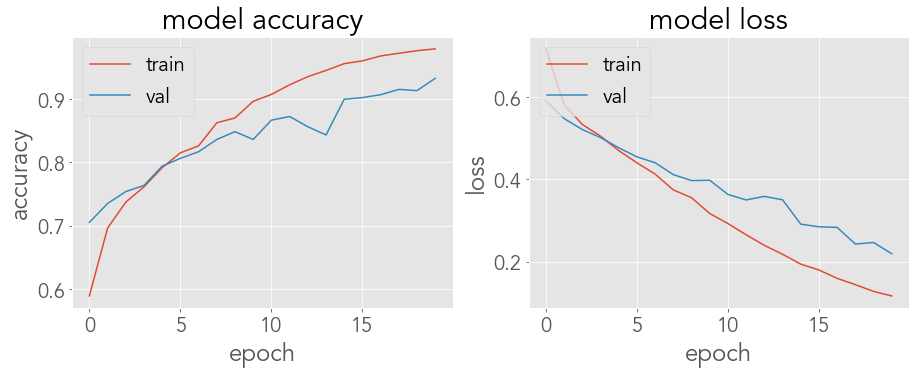

In [32]:
model_c1 = keras.models.Sequential([
    keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(128, 128, 3), padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(2,  activation = "softmax")
])


opt = keras.optimizers.Adam(learning_rate=0.0001)

model_c1.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history =model_c1.fit(train_images, train_labels, epochs=20, validation_split=0.2, verbose=1)

#Plot accuracy
plot_accuracy(history)


Test data, accuracy: 93.01%


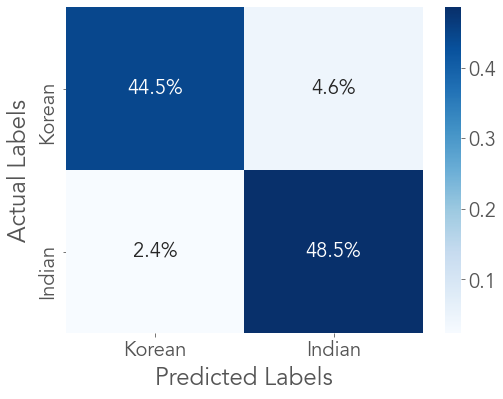

In [33]:
# Evaluate model with test images
test_loss, test_acc = model_c1.evaluate(test_images, test_labels, verbose=0)
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))

# Make predictions on test set
prediction = model_c1.predict(test_images)
predicted_labels = np.argmax(prediction, axis=1)

# Make Confusion matrix plot
plot_confusion_matrix(test_labels, predicted_labels)

## First model with 2 filter layers

Train on 6174 samples, validate on 1544 samples
Epoch 1/20
6174/6174 [==============================] - 41s 7ms/sample - loss: 0.6019 - accuracy: 0.6723 - val_loss: 0.5013 - val_accuracy: 0.7552
Epoch 2/20
6174/6174 [==============================] - 42s 7ms/sample - loss: 0.4194 - accuracy: 0.8183 - val_loss: 0.4010 - val_accuracy: 0.8076
Epoch 3/20
6174/6174 [==============================] - 41s 7ms/sample - loss: 0.2913 - accuracy: 0.8971 - val_loss: 0.3073 - val_accuracy: 0.8925
Epoch 4/20
6174/6174 [==============================] - 41s 7ms/sample - loss: 0.2041 - accuracy: 0.9351 - val_loss: 0.3363 - val_accuracy: 0.8556
Epoch 5/20
6174/6174 [==============================] - 41s 7ms/sample - loss: 0.1352 - accuracy: 0.9637 - val_loss: 0.2290 - val_accuracy: 0.9132
Epoch 6/20
6174/6174 [==============================] - 41s 7ms/sample - loss: 0.0927 - accuracy: 0.9786 - val_loss: 0.1892 - val_accuracy: 0.9378
Epoch 7/20
6174/6174 [==============================] - 41s 7ms/sample

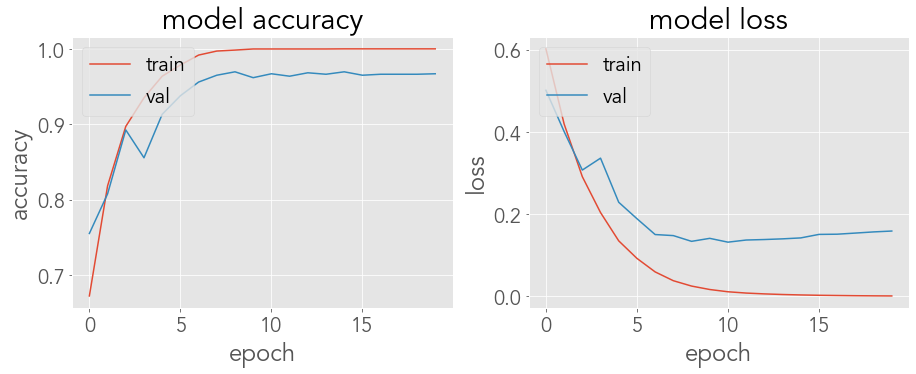

In [34]:
model_c2 = keras.models.Sequential([
    keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(128, 128, 3), padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (5, 5), activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(3,  activation = "softmax")
])

model_c2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history =model_c2.fit(train_images, train_labels, epochs=20, validation_split=0.2, verbose=1)

#Plot accuracy
plot_accuracy(history)


Test data, accuracy: 95.85%


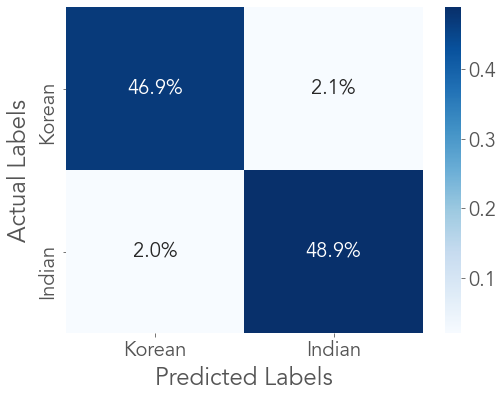

In [35]:
# Evaluate model with test images
test_loss, test_acc = model_c2.evaluate(test_images, test_labels, verbose=0)
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))

# Make predictions on test set
prediction = model_c2.predict(test_images)
predicted_labels = np.argmax(prediction, axis=1)

# Make Confusion matrix plot
plot_confusion_matrix(test_labels, predicted_labels)

## Adding dropout layers to reduce overfitting

Train on 6174 samples, validate on 1544 samples
Epoch 1/50
6174/6174 [==============================] - 44s 7ms/sample - loss: 0.7182 - accuracy: 0.5758 - val_loss: 0.6100 - val_accuracy: 0.6982
Epoch 2/50
6174/6174 [==============================] - 44s 7ms/sample - loss: 0.5851 - accuracy: 0.6905 - val_loss: 0.5702 - val_accuracy: 0.7196
Epoch 3/50
6174/6174 [==============================] - 44s 7ms/sample - loss: 0.5596 - accuracy: 0.7063 - val_loss: 0.5610 - val_accuracy: 0.7228
Epoch 4/50
6174/6174 [==============================] - 44s 7ms/sample - loss: 0.5390 - accuracy: 0.7272 - val_loss: 0.5426 - val_accuracy: 0.7273
Epoch 5/50
6174/6174 [==============================] - 43s 7ms/sample - loss: 0.5224 - accuracy: 0.7421 - val_loss: 0.5260 - val_accuracy: 0.7370
Epoch 6/50
6174/6174 [==============================] - 43s 7ms/sample - loss: 0.5037 - accuracy: 0.7489 - val_loss: 0.5245 - val_accuracy: 0.7494
Epoch 7/50
6174/6174 [==============================] - 43s 7ms/sample

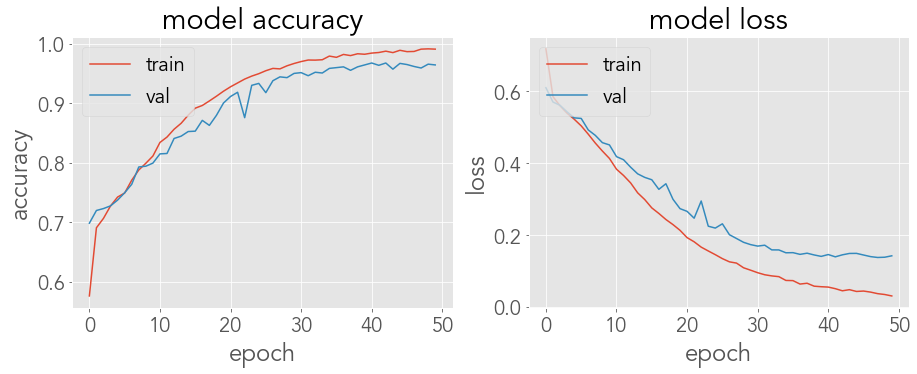

In [36]:
model_c2_d2 = keras.models.Sequential([
    keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(128, 128, 3), padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, (5, 5), activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(2,2),
     keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(2,  activation = "softmax")
])

model_c2_d2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history =model_c2_d2.fit(train_images, train_labels, epochs=50, validation_split=0.2, verbose=1)

#Plot accuracy
plot_accuracy(history)


Test data, accuracy: 96.84%


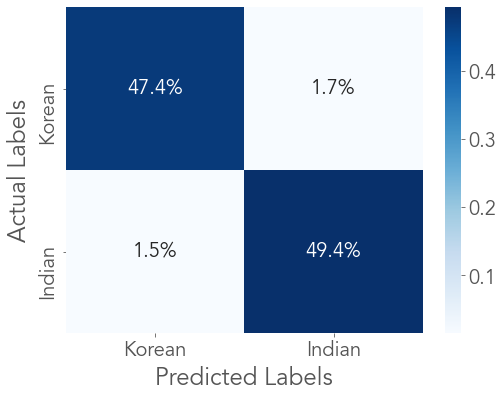

In [43]:
# Evaluate model with test images
test_loss, test_acc = model_c2_d2.evaluate(test_images, test_labels, verbose=0)
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))

# Make predictions on test set
prediction = model_c2_d2.predict(test_images)
predicted_labels = np.argmax(prediction, axis=1)

# Make Confusion matrix plot
plot_confusion_matrix(test_labels, predicted_labels)

In [45]:
model_c2_d2.save('model_c2_d2')
model_c2_d2.save('model_c2_d2.h5')

INFO:tensorflow:Assets written to: model_c2_d2/assets


INFO:tensorflow:Assets written to: model_c2_d2/assets


Train on 6174 samples, validate on 1544 samples
Epoch 1/75
6174/6174 [==============================] - 47s 8ms/sample - loss: 0.6628 - accuracy: 0.6310 - val_loss: 0.6318 - val_accuracy: 0.6794
Epoch 2/75
6174/6174 [==============================] - 47s 8ms/sample - loss: 0.5709 - accuracy: 0.7036 - val_loss: 0.5925 - val_accuracy: 0.7008
Epoch 3/75
6174/6174 [==============================] - 47s 8ms/sample - loss: 0.5325 - accuracy: 0.7328 - val_loss: 0.5577 - val_accuracy: 0.7429
Epoch 4/75
6174/6174 [==============================] - 46s 7ms/sample - loss: 0.5009 - accuracy: 0.7582 - val_loss: 0.5259 - val_accuracy: 0.7468
Epoch 5/75
6174/6174 [==============================] - 46s 7ms/sample - loss: 0.4724 - accuracy: 0.7786 - val_loss: 0.4980 - val_accuracy: 0.7850
Epoch 6/75
6174/6174 [==============================] - 46s 7ms/sample - loss: 0.4362 - accuracy: 0.8013 - val_loss: 0.4762 - val_accuracy: 0.7863
Epoch 7/75
6174/6174 [==============================] - 46s 7ms/sample

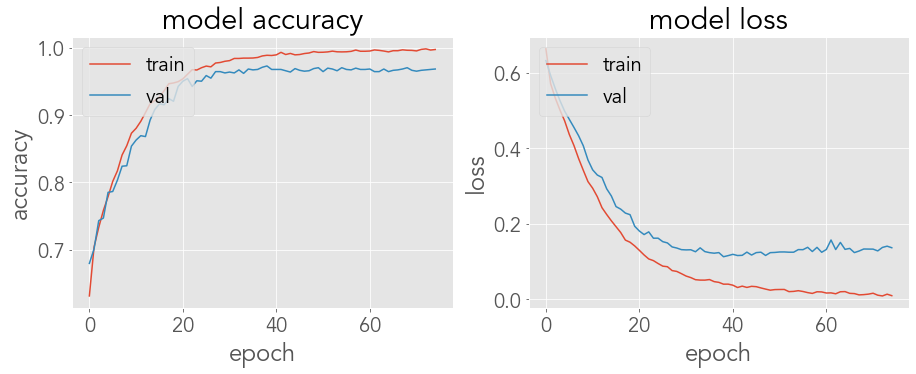

In [46]:
model_c2_d2_2 = keras.models.Sequential([
    keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(128, 128, 3), padding = "same"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(32, (5, 5), activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(2,2),
     keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(2,  activation = "softmax")
])

model_c2_d2_2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history =model_c2_d2_2.fit(train_images, train_labels, epochs=75, validation_split=0.2, verbose=1)

#Plot accuracy
plot_accuracy(history)


Test data, accuracy: 97.31%


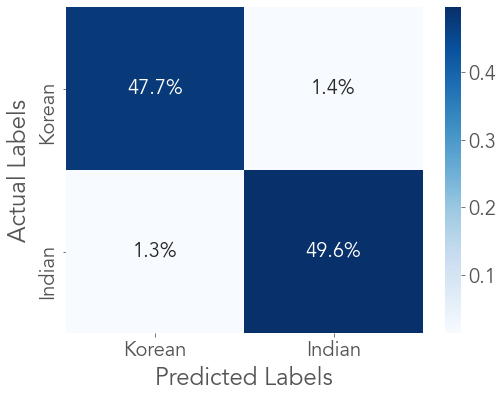

In [48]:
# Evaluate model with test images
test_loss, test_acc = model_c2_d2_2.evaluate(test_images, test_labels, verbose=0)
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))

# Make predictions on test set
prediction = model_c2_d2_2.predict(test_images)
predicted_labels = np.argmax(prediction, axis=1)

# Make Confusion matrix plot
plot_confusion_matrix(test_labels, predicted_labels)

In [49]:
model_c2_d2_2.save('model_c2_d2_2')
model_c2_d2_2.save('model_c2_d2_2.h5')

INFO:tensorflow:Assets written to: model_c2_d2_2/assets


INFO:tensorflow:Assets written to: model_c2_d2_2/assets


## Looking at test images and results

In [38]:
results = pd.DataFrame({"real":test_labels, "predicted": predicted_labels})
results['real']=results['real'].astype(int)

incorrect = results[results['real']!=results['predicted']]
incorrect_list= list(incorrect.index.values)

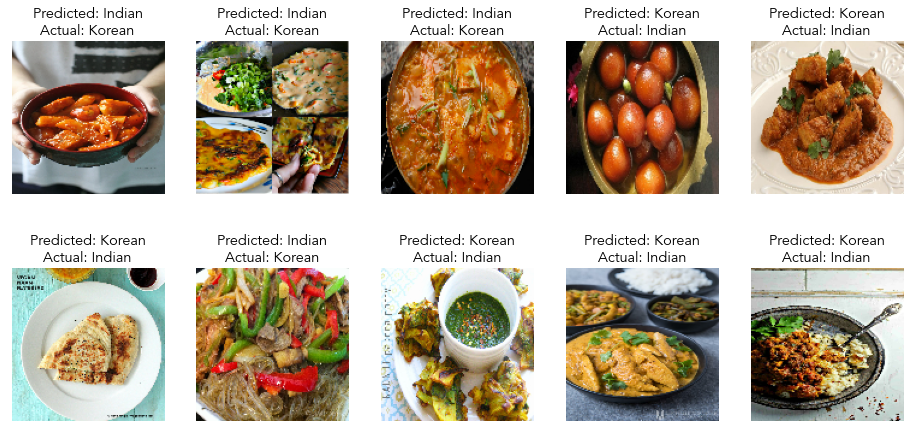

In [41]:
label_dict = {0: "Korean", 1: "Indian"}
plt.figure(figsize=(16, 16))
plt.rcParams["font.size"] = 10
count =1
for item in incorrect_list[30:40]:
    img = load_and_preprocess_image(df_test["filepath"].iloc[item])
    label = df_test["label"].iloc[item] 
    plt.subplot(4, 5, count)
    count +=1
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    if label == 0:
        plt.title(f"Predicted: {label_dict[predicted_labels[item]]}\nActual: Korean")
    elif label==1:
        plt.title(f"Predicted: {label_dict[predicted_labels[item]]}\nActual: Indian")

plt.show()

## Pickling data 

In [ ]:
data = (train_images, train_labels, test_images, test_labels)

with open('cuisin_500_test_train.pkl', 'wb') as f:
    pickle.dump(data, f)

## Loading pickled data

In [ ]:
#Load the data - No need to do Feature Engineering again
with open('cuisin_500_test_train.pkl','rb') as f:
     (train_images, train_labels, test_images, test_labels) = pickle.load(f)